# Creating Node Representations with DeepWalk

In [1]:
import numpy as np
np.random.seed(0)

CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
""".split()

# Create skipgrams
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

print(skipgrams[0:3])

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur']), ('amet,', ['dolor', 'sit', 'consectetur', 'adipiscing'])]


In [2]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f"Length of vocabulary = {VOCAB_SIZE}")

Length of vocabulary = 121


In [3]:
from gensim.models.word2vec import Word2Vec

# Create Word2Vec
model = Word2Vec([text],
                 sg=1,   # Skip-gram
                 vector_size=10,
                 min_count=0,
                 window=2,
                 workers=1,
                 seed=0)

print(f'Shape of W_embed: {model.wv.vectors.shape}')

# Train model
model.train([text], total_examples=model.corpus_count, epochs=20)

# Print a word embedding
print('\nWord embedding =')
print(model.wv[0])

Shape of W_embed: (121, 10)

Word embedding =
[ 0.07366448  0.03862958  0.0021651  -0.04142977 -0.03031607 -0.08006149
 -0.09811321 -0.0959207  -0.06454173  0.07042638]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


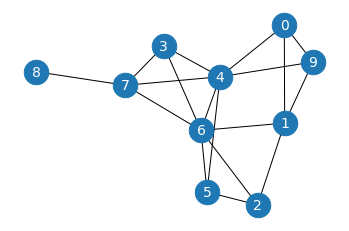

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [9]:
import random
random.seed(0)

def random_walk(start, length):
    walk = [str(start)]  # starting node
    
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        # print(start, neighbors)
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    
    return walk

# Create a list of random walks
print(random_walk(2, 10))

['2', '1', '9', '4', '6', '3', '4', '5', '2', '1', '0']


Officer


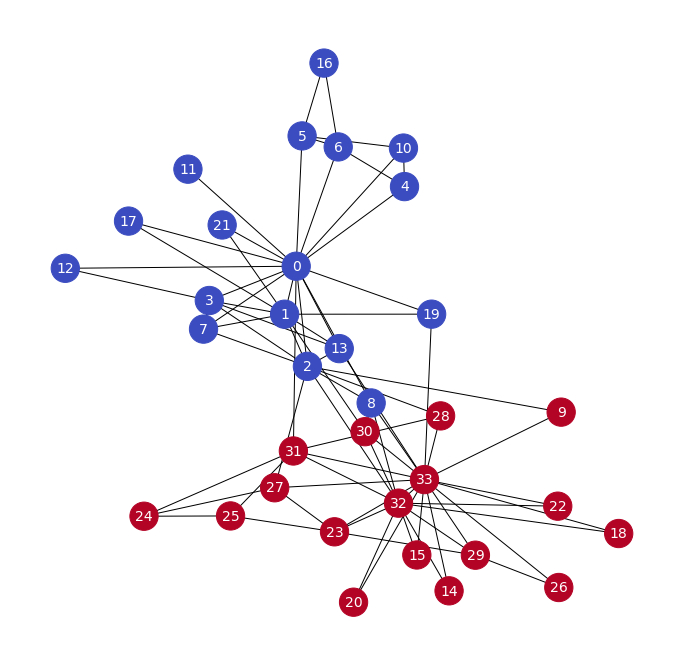

In [18]:
# Load dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [22]:
# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

# Print the first random walk
print(walks[0])

['0', '7', '1', '2', '3', '13', '3', '13', '1', '3', '13']


In [25]:
# Create Word2Vec
model = Word2Vec(walks,
                 hs=1,   # Hierarchical softmax
                 sg=1,   # Skip-gram
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f'Shape of embedding matrix: {model.wv.vectors.shape}')

# Build vocabulary
model.build_vocab(walks)

# Train model
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

Shape of embedding matrix: (34, 100)


(187728, 897600)

In [27]:
# Most similar nodes
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

# Similarity between two nodes
print(f"\nSimilarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Nodes that are the most similar to node 0:
   ('4', 0.7043484449386597)
   ('11', 0.6559093594551086)
   ('7', 0.6416646838188171)
   ('10', 0.6370264887809753)
   ('5', 0.6253332495689392)
   ('12', 0.6197181940078735)
   ('6', 0.6161673069000244)
   ('16', 0.6025732755661011)
   ('21', 0.5717868208885193)
   ('3', 0.5691187977790833)

Similarity between node 0 and 4: 0.7043483853340149


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


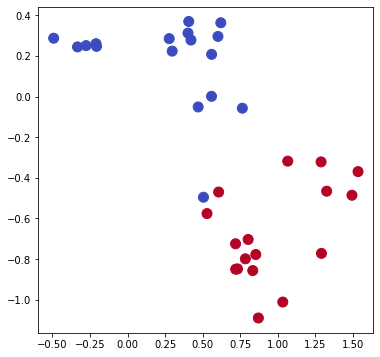

In [26]:
from sklearn.manifold import TSNE

# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

# Train TSNE
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Train classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

# Evaluate accuracy
y_pred = clf.predict(nodes_wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Accuracy = {acc*100:.2f}%')

Accuracy = 95.45%
